# COMP0189: Applied Artificial Intelligence

## Week 4 (Linear models, Trees and Ensemble Models )

### After this week you will be able to ...    
    - run various regularized linear models and optimize their regularization parameter in a proper way
    - visualize coefficient of linear models
    - run tree based and emsemble models
    - visualize feature importane for tree based models


   



We will use the Housing dataset for predicting house prices. It includes a variety of features that are commonly believed to influence the price of a house. These features include aspects like the size of the house, the number of bedrooms and bathrooms, location, and other relevant attributes.



### Acknowledgements
- https://scikit-learn.org/stable/
- Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.
Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

- https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Task 1: Create a pipeline for hyper-parameter tuning and model comparison

1.1 Create a pipeline to optize the regularization hyper-paramaters of different linear models (Ridge regression, LASSO and elastic-net) and chose the best model for predicting house prices based on the features provided. Print the average cross-validation performance (with the standard deviation) as well as the test performance.

Linear models: https://scikit-learn.org/stable/modules/linear_model.html#

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import math
import pandas as pd
from scipy.stats import loguniform
import numpy as np
import random

random.seed(10)


# Assuming 'df' is your DataFrame

categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
numerical_features = df.drop(columns=['price'] + categorical_features).columns.tolist()

# Split categorical features into binary and non-binary
binary_categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
non_binary_categorical_features = ['furnishingstatus']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin_cat', OrdinalEncoder(), binary_categorical_features),
        ('non_bin_cat', OneHotEncoder(), non_binary_categorical_features)
    ])

# Define X and y
X = df.drop('price', axis=1)
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Define the parameter grids for each model
ridge_params = {'regressor__alpha': np.logspace(-2, 10, 100)}
lasso_params = {'regressor__alpha': np.logspace(-2, 10, 100)}
elastic_params = {'regressor__alpha': np.logspace(-2, 10, 100), 'regressor__l1_ratio': [0.01, 0.2, 0.5, 0.8]}


def perform_grid_search(model, param_grid):
    grid_search = GridSearchCV(Pipeline([
                            ('preprocessor', preprocessor),
                            ('regressor', model)]),
                            param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Best parameters and CV score
    print(f"Best parameters for {model.__class__.__name__}: ", grid_search.best_params_)
    print(f"Best average CV score for {model.__class__.__name__}: ", -grid_search.best_score_)

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = math.sqrt(test_mse)  # Calculate RMSE
    test_r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE for {model.__class__.__name__}: ", test_rmse)
    print(f"Test R-squared for {model.__class__.__name__}: ", test_r2)

    # Store results with all required arguments
    store_results(model.__class__.__name__, grid_search, test_rmse, test_r2)

    return grid_search


# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best CV Score', 'Test RMSE', 'Test R2'])

def store_results(model_name, grid_search, test_rmse, test_r2):
    best_params = grid_search.best_params_
    best_cv_score = -grid_search.best_score_

    # Append results to the DataFrame
    results_df.loc[len(results_df)] = [model_name, best_params, best_cv_score, test_rmse, test_r2]


# Perform GridSearchCV for each model and store results
grid_search_ridge = perform_grid_search(Ridge(max_iter=10000), ridge_params)
#store_results('Ridge', grid_search_ridge)

grid_search_lasso = perform_grid_search(Lasso(max_iter=10000), lasso_params)
#store_results('Lasso', grid_search_lasso)

grid_search_elastic = perform_grid_search(ElasticNet(max_iter=10000), elastic_params)
#store_results('ElasticNet', grid_search_elastic)

# Display the results
results_df






Best parameters for Ridge:  {'regressor__alpha': 2.656087782946687}
Best average CV score for Ridge:  1237167481635.5718
Test RMSE for Ridge:  972699.2793508288
Test R-squared for Ridge:  0.671650903374506
Best parameters for Lasso:  {'regressor__alpha': 2848.035868435805}
Best average CV score for Lasso:  1240188482698.3523
Test RMSE for Lasso:  979312.573831464
Test R-squared for Lasso:  0.6671708937223337
Best parameters for ElasticNet:  {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.2}
Best average CV score for ElasticNet:  1237163757529.9067
Test RMSE for ElasticNet:  969147.9832704817
Test R-squared for ElasticNet:  0.674044112150362


,Model,Best Parameters,Best CV Score,Test RMSE,Test R2
0,Ridge,{'regressor__alpha': 2.656087782946687},1.237167e+12,972699.279351,0.671651
1,Lasso,{'regressor__alpha': 2848.035868435805},1.240188e+12,979312.573831,0.667171
2,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_rati...",1.237164e+12,969147.983270,0.674044


1.2 Create a plot to show the performance of the different models during hyper-parameter optimization (i.e. the figure should show for each model how the performance varies for the different hyper-parameter value)

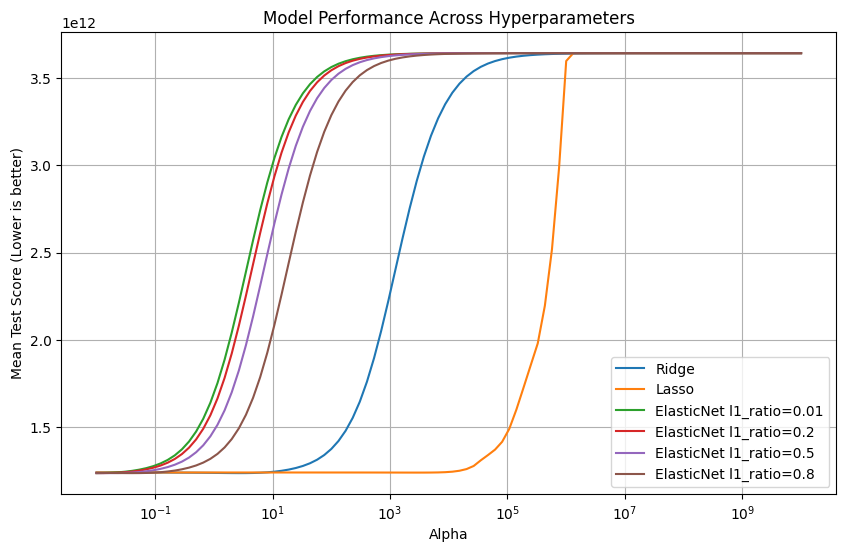

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

def plot_model_performance(grid_search, model_name, ax):
    results = pd.DataFrame(grid_search.cv_results_)
    if model_name != 'ElasticNet':
        # For Ridge and Lasso
        alphas = results['param_regressor__alpha']
        scores = -results['mean_test_score']  # Negate to get MSE
        ax.semilogx(alphas, scores, label=model_name, linestyle='-')

    else:
        # For ElasticNet, need to handle combinations of alpha and l1_ratio
        alphas = results['param_regressor__alpha']
        l1_ratios = results['param_regressor__l1_ratio']
        scores = -results['mean_test_score']  # Negate to get MSE

        # Unique l1_ratios for plotting
        unique_l1_ratios = np.unique(l1_ratios)
        for l1_ratio in unique_l1_ratios:
            # Filter scores for each l1_ratio
            indices = l1_ratios == l1_ratio
            ax.semilogx(alphas[indices], scores[indices], label=f'ElasticNet l1_ratio={l1_ratio}', linestyle='-')

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the performance of each model on the same axis
plot_model_performance(grid_search_ridge, 'Ridge', ax)
plot_model_performance(grid_search_lasso, 'Lasso', ax)
plot_model_performance(grid_search_elastic, 'ElasticNet', ax)

# Set labels, title, legend, and grid for the plot
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Test Score (Lower is better)')
ax.set_title('Model Performance Across Hyperparameters')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()




1.3 Create figures to show the models coefficients for model interpretation (i.e. including the feature names).

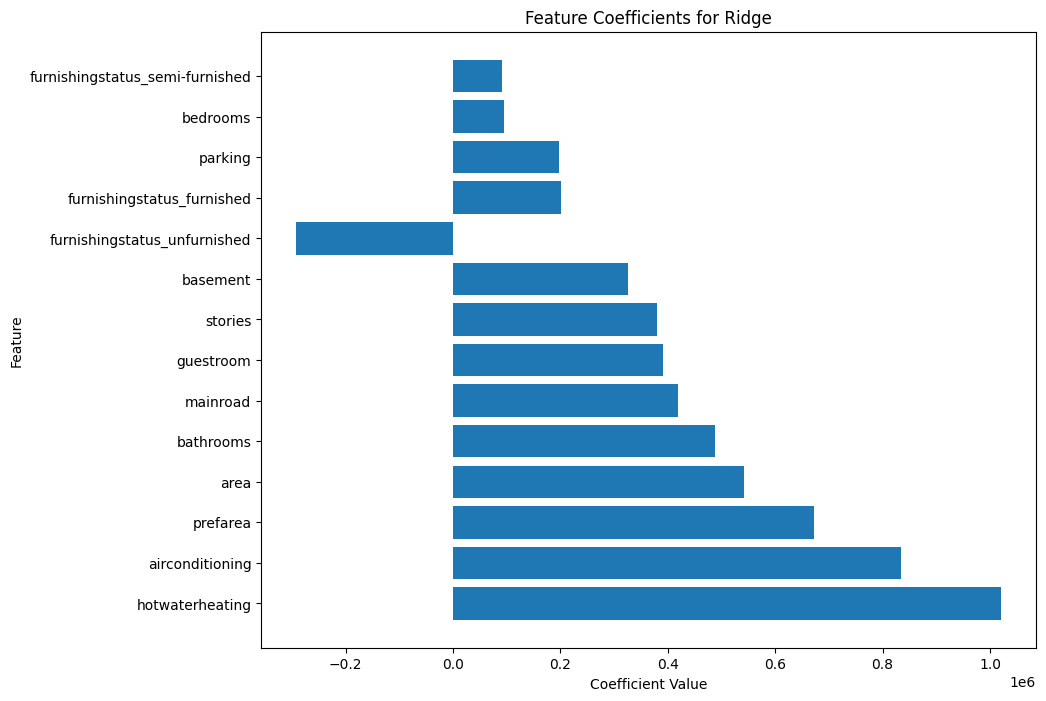

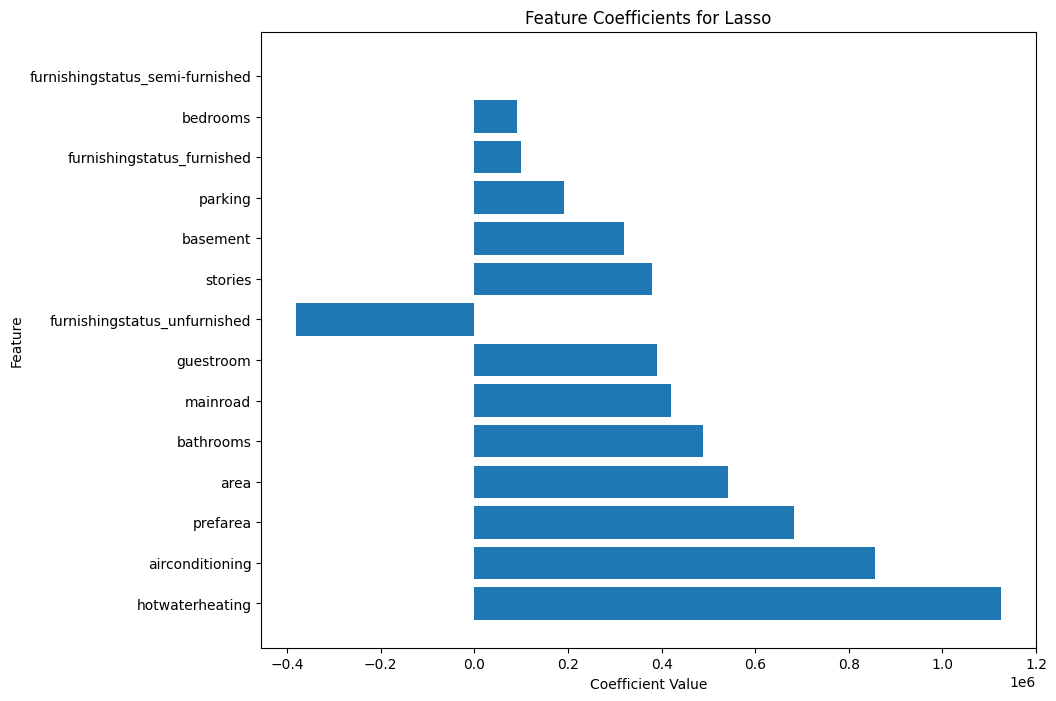

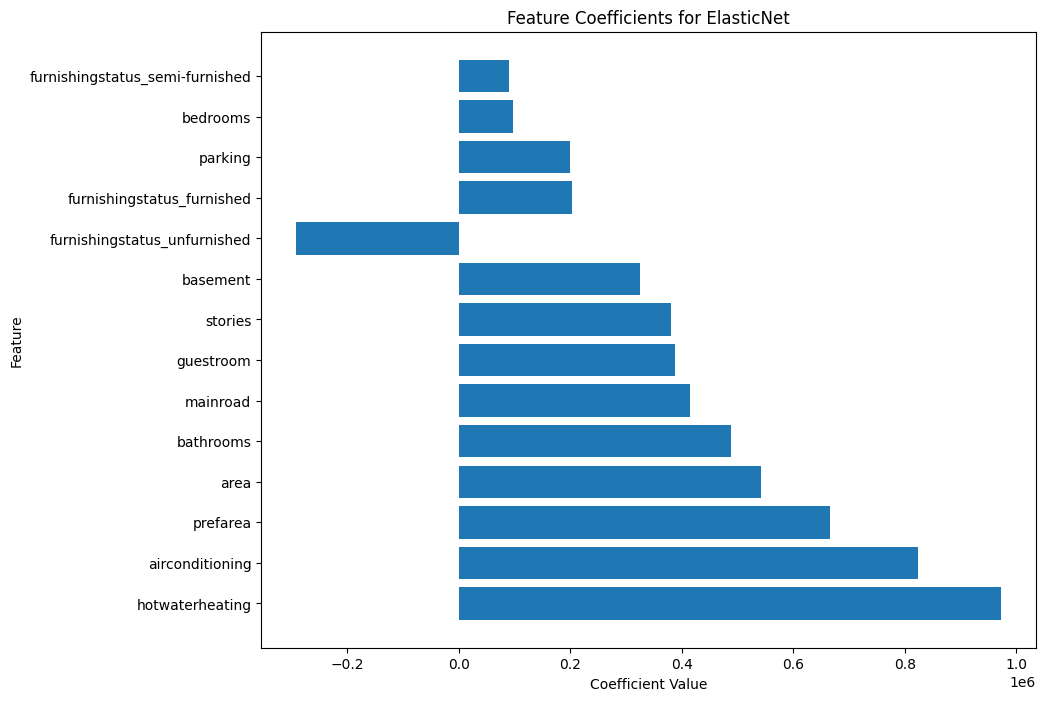

In [29]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Function to plot model coefficients
def plot_model_coefficients(model, model_name, numerical_features, categorical_features):
    # Extract coefficients
    coefs = model.named_steps['regressor'].coef_

    # For binary categorical features, use the original feature names
    binary_feature_names = binary_categorical_features

    # For non-binary categorical features, get the feature names from the OneHotEncoder
    non_bin_ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['non_bin_cat'].get_feature_names_out()

    # Combine all feature names
    feature_names = np.concatenate([numerical_features, binary_feature_names, non_bin_ohe_feature_names])


    # Sort the coefficients and corresponding feature names
    sorted_indices = np.argsort(np.abs(coefs))[::-1]
    sorted_coefs = coefs[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_coefs)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Feature Coefficients for {model_name}')
    plt.show()

# Extract best models
best_ridge = grid_search_ridge.best_estimator_
best_lasso = grid_search_lasso.best_estimator_
best_elastic = grid_search_elastic.best_estimator_

# Assume best_ridge, best_lasso, best_elastic are already defined and are the best estimators from GridSearchCV
plot_model_coefficients(best_ridge, "Ridge", numerical_features, categorical_features)
plot_model_coefficients(best_lasso, "Lasso", numerical_features, categorical_features)
plot_model_coefficients(best_elastic, "ElasticNet", numerical_features, categorical_features)






1.4 Create a similarity matrix to show the similarity of the coefficents across the different models

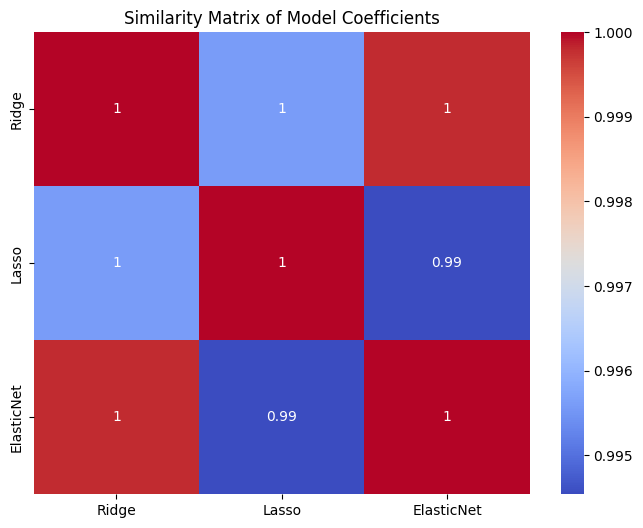

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract coefficients
ridge_coefs = best_ridge.named_steps['regressor'].coef_
lasso_coefs = best_lasso.named_steps['regressor'].coef_
elastic_coefs = best_elastic.named_steps['regressor'].coef_

# Form a matrix of coefficients
coefs_matrix = [ridge_coefs, lasso_coefs, elastic_coefs]

# Calculate similarity matrix
similarity_matrix = cosine_similarity(coefs_matrix)

# Convert the matrix to a DataFrame for better readability
similarity_df = pd.DataFrame(similarity_matrix, index=["Ridge", "Lasso", "ElasticNet"], columns=["Ridge", "Lasso", "ElasticNet"])

# Plotting the similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm")
plt.title("Similarity Matrix of Model Coefficients")
plt.show()




### Discussion: How does the performance compare across models? Are the coefficients similar across models?

## Task 2: Create an example of wrong pipeline for task 1.1 and the average CV as well as the test performance.

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define X and y
X = df.drop('price', axis=1)
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


# Define the parameter grids for each model
ridge_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
elastic_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100], 'regressor__l1_ratio': [0.2, 0.5, 0.8]}


def perform_grid_search(model, param_grid):
    grid_search = GridSearchCV(Pipeline([
                            ('preprocessor', preprocessor),
                            ('regressor', model)]),
                            param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    # Best parameters and CV score
    print(f"Best parameters for {model.__class__.__name__}: ", grid_search.best_params_)
    print(f"Best average CV score for {model.__class__.__name__}: ", -grid_search.best_score_)

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = math.sqrt(test_mse)  # Calculate RMSE
    test_r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE for {model.__class__.__name__}: ", test_rmse)
    print(f"Test R-squared for {model.__class__.__name__}: ", test_r2)

    # Return the GridSearchCV object instead of the best estimator
    return grid_search

# Perform GridSearchCV for each model
grid_search_ridge = perform_grid_search(Ridge(), ridge_params)
grid_search_lasso = perform_grid_search(Lasso(max_iter=10000), lasso_params)
grid_search_elastic = perform_grid_search(ElasticNet(max_iter=10000), elastic_params)




Best parameters for Ridge:  {'regressor__alpha': 0.01}
Best average CV score for Ridge:  2120462328712.9062
Test RMSE for Ridge:  941701.5061256895
Test R-squared for Ridge:  0.6922449645283748
Best parameters for Lasso:  {'regressor__alpha': 0.01}
Best average CV score for Lasso:  2120447139499.6804
Test RMSE for Lasso:  941713.9365207272
Test R-squared for Lasso:  0.692236839784198
Best parameters for ElasticNet:  {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.8}
Best average CV score for ElasticNet:  2121809347290.1028
Test RMSE for ElasticNet:  940403.0660923198
Test R-squared for ElasticNet:  0.6930930591019044


**Discussion**  
**Did the model performance changed when using a wrong pipeline?**

## Task 3: Tree and ensemble models

3.1 For the same dataset compare the performance of a decision tree and ensemble methods (bagging, boosting and gradient boosting) on predicting the house prices. Compute the feature importance for the different models. Create a table/plots to show the performance of the different models.

Trees: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree  
Ensembles: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor


In [31]:
from sklearn.pipeline import Pipeline

# Initialize models with a pipeline
decision_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
bagging = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0))
])
boosting = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=0))
])
gradient_boosting = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=0))
])

models = {
    "Decision Tree": decision_tree,
    "Bagging": bagging,
    "Boosting": boosting,
    "Gradient Boosting": gradient_boosting
}


# Define parameter grids
decision_tree_params = {'regressor__max_depth': [3, 5, 10, 20]}
bagging_params = {'regressor__n_estimators': [10, 20, 50]}
boosting_params = {'regressor__n_estimators': [50, 100, 200], 'regressor__learning_rate': [0.01, 0.1, 1]}
gradient_boosting_params = {'regressor__n_estimators': [100, 200, 300], 'regressor__learning_rate': [0.01, 0.1, 0.2]}


# Create a dictionary to hold the parameter grids
param_grids = {
    "Decision Tree": decision_tree_params,
    "Bagging": bagging_params,
    "Boosting": boosting_params,
    "Gradient Boosting": gradient_boosting_params
}

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best CV Score', 'Test RMSE', 'Test R2'])

# Function to perform grid search and store results
def perform_grid_search(model_name, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Best parameters and CV score
    best_params = grid_search.best_params_
    best_cv_score = -grid_search.best_score_

    # Evaluate on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Append results to the DataFrame
    results_df.loc[len(results_df)] = [model_name, best_params, best_cv_score, test_rmse, test_r2]

    print(f"Best parameters for {model_name}: ", best_params)
    print(f"Best average CV score for {model_name}: ", best_cv_score)
    print(f"Test RMSE for {model_name}: ", test_rmse)
    print(f"Test R-squared for {model_name}: ", test_r2)

# Perform GridSearchCV for each model and store results
for name, model in models.items():
    perform_grid_search(name, model, param_grids[name])


# Display the results
results_df




Best parameters for Decision Tree:  {'regressor__max_depth': 3}
Best average CV score for Decision Tree:  1918042019688.6785
Test RMSE for Decision Tree:  1348618.3916226875
Test R-squared for Decision Tree:  0.3688148195212726


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best parameters for Bagging:  {'regressor__n_estimators': 50}
Best average CV score for Bagging:  1439605121664.105
Test RMSE for Bagging:  1143074.4302403766
Test R-squared for Bagging:  0.546551825823989


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best parameters for Boosting:  {'regressor__learning_rate': 1, 'regressor__n_estimators': 50}
Best average CV score for Boosting:  1449422424938.0332
Test RMSE for Boosting:  1036553.4800349073
Test R-squared for Boosting:  0.6271260309458446
Best parameters for Gradient Boosting:  {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 300}
Best average CV score for Gradient Boosting:  1416595192097.6687
Test RMSE for Gradient Boosting:  1044465.5436351199
Test R-squared for Gradient Boosting:  0.6214119754040126


,Model,Best Parameters,Best CV Score,Test RMSE,Test R2
0,Decision Tree,{'regressor__max_depth': 3},1.918042e+12,1.348618e+06,0.368815
1,Bagging,{'regressor__n_estimators': 50},1.439605e+12,1.143074e+06,0.546552
2,Boosting,"{'regressor__learning_rate': 1, 'regressor__n_...",1.449422e+12,1.036553e+06,0.627126
3,Gradient Boosting,"{'regressor__learning_rate': 0.01, 'regressor_...",1.416595e+12,1.044466e+06,0.621412


3.2 Create figures to show the feature importance for the different models

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


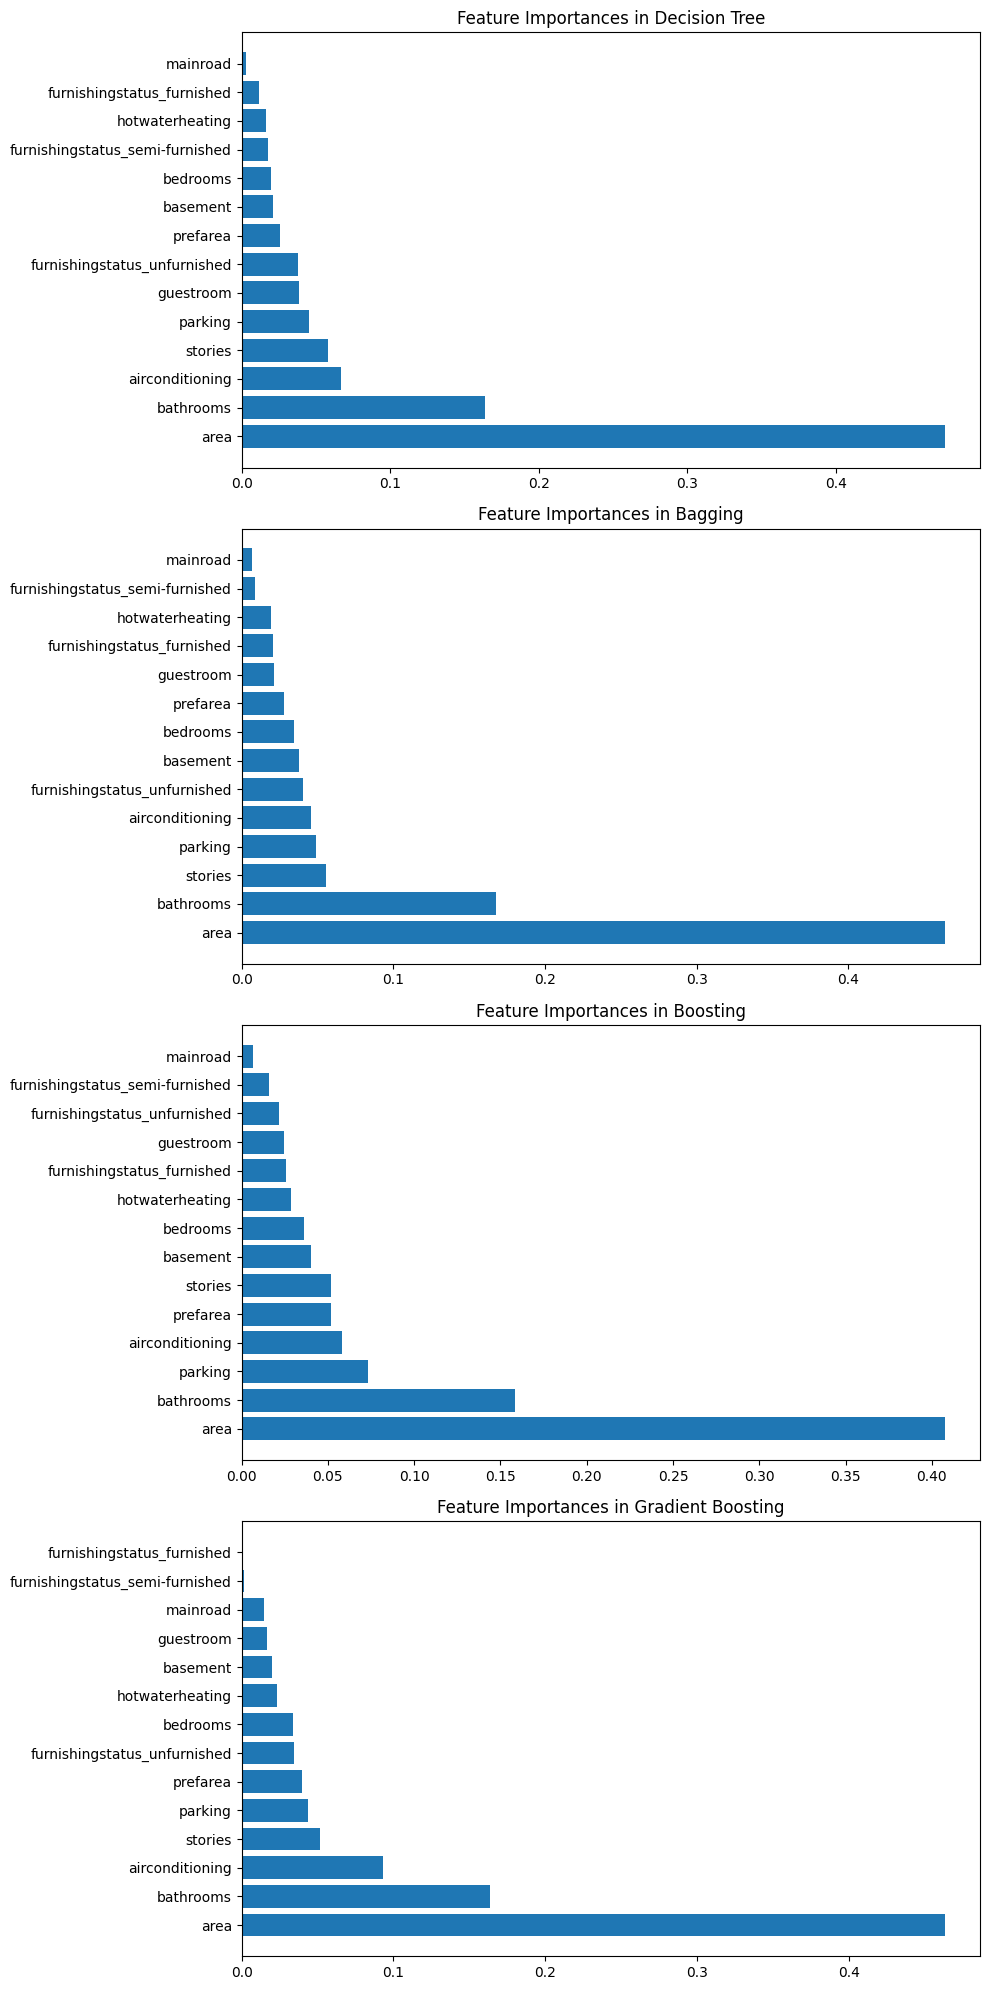

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names after preprocessing
preprocessor.fit(X_train)


# For binary categorical features, use the original feature names
binary_feature_names = binary_categorical_features

# For non-binary categorical features, get the feature names from the OneHotEncoder
non_bin_ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['non_bin_cat'].get_feature_names_out()

# Combine all feature names
feature_names = np.concatenate([numerical_features, binary_feature_names, non_bin_ohe_feature_names])

# Fit each model
for name, model in models.items():
    model.fit(X_train, y_train)

def plot_feature_importances(model, name, feature_names, ax):
    # Extract the regressor from the pipeline
    if isinstance(model, Pipeline):
        regressor = model.named_steps['regressor']
    else:
        regressor = model

    # Handle BaggingRegressor and get feature importances
    if isinstance(regressor, BaggingRegressor):
        importances = np.mean([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
    else:
        importances = regressor.feature_importances_

    indices = np.argsort(importances)[::-1]

    # Adjust the feature names if their number doesn't match the importances length
    if len(feature_names) != len(importances):
        # Handle transformed feature names
        transformed_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
        adjusted_feature_names = [transformed_feature_names[i] for i in indices]
    else:
        adjusted_feature_names = [feature_names[i] for i in indices]

    # Plot feature importances
    ax.barh(range(len(indices)), importances[indices], align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(adjusted_feature_names)
    ax.set_title(f'Feature Importances in {name}')

# Plotting feature importances for each model
fig, axs = plt.subplots(len(models), figsize=(10, 5 * len(models)))
if len(models) == 1:  # Handle the case of a single model
    axs = [axs]
for ax, (name, model) in zip(axs, models.items()):
    plot_feature_importances(model, name, feature_names, ax)

plt.tight_layout()
plt.show()

**Discussion**  
**Were the features selected similar across the different models?**

3.3 Compare two different approaches for prunning a decision tree (cost-complexity prunning and max leaves nodes) and plot the resulting trees.

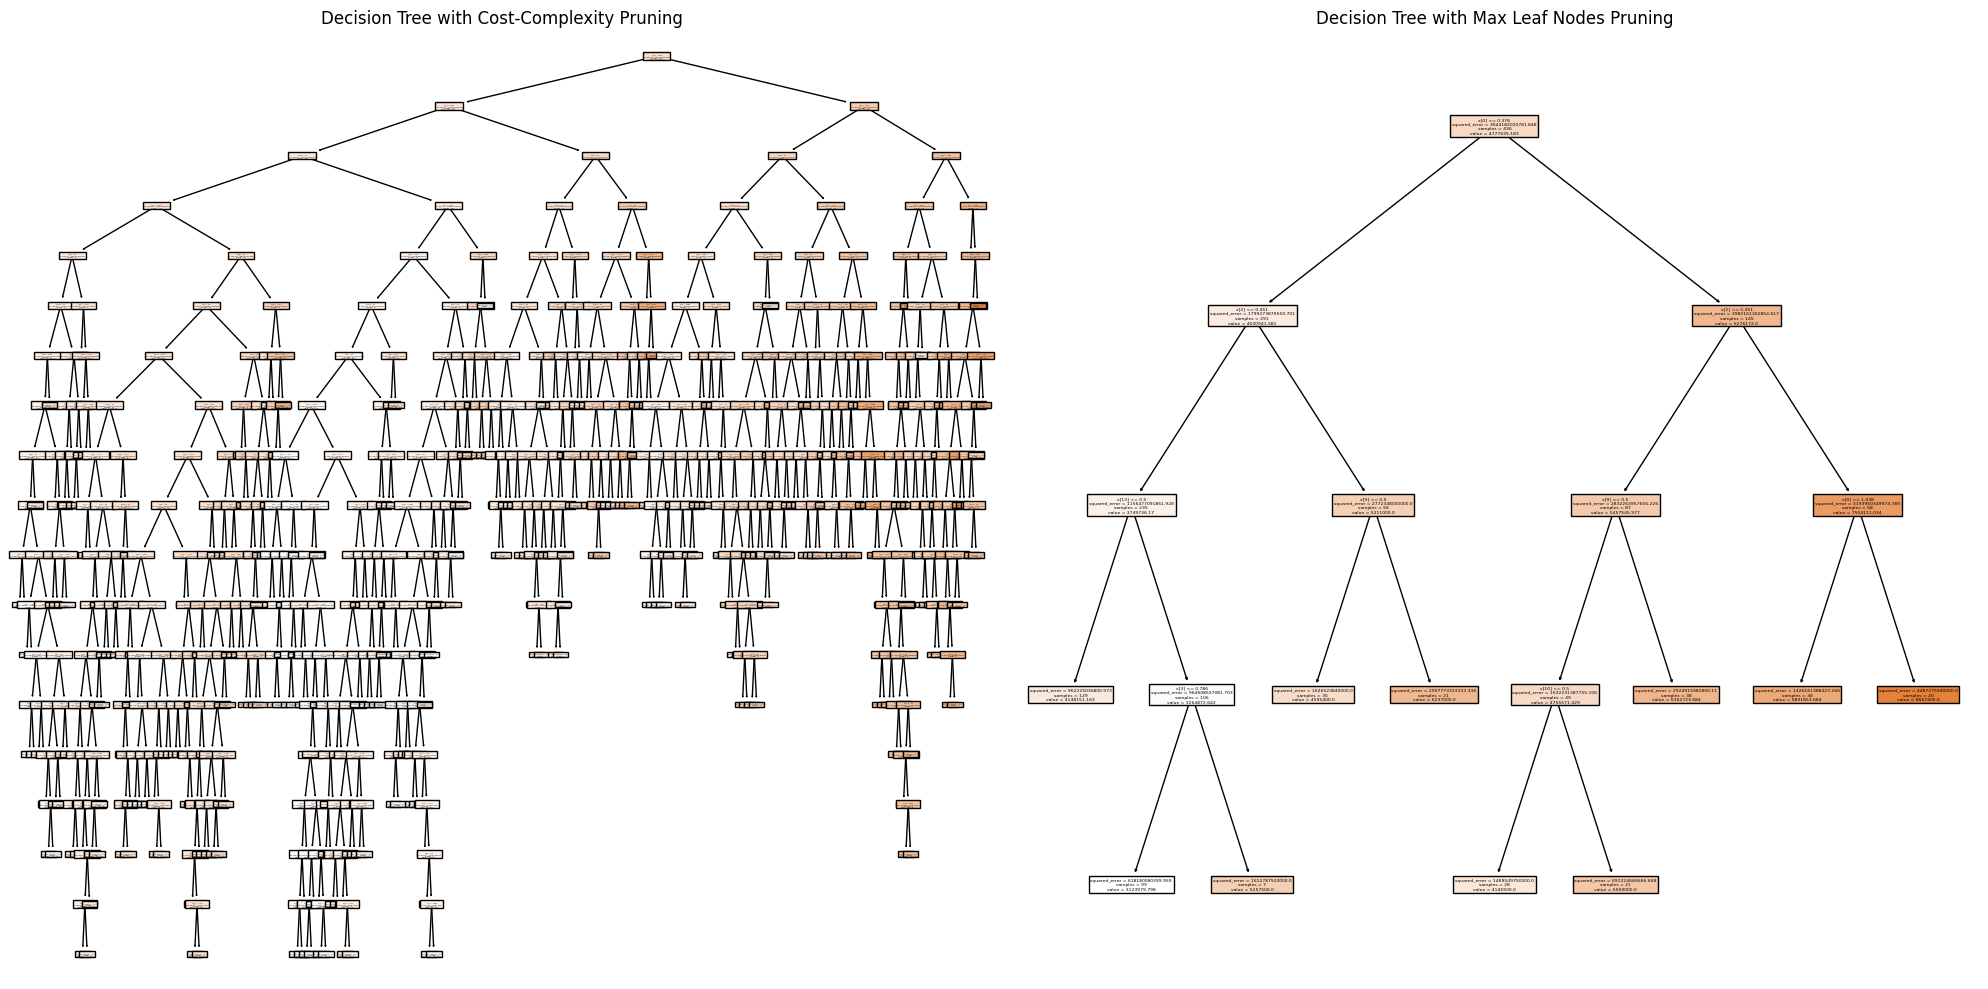

In [35]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import math
import pandas as pd

# Initialize decision tree model with a pipeline
decision_tree_ccp = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
decision_tree_max_leaf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0))
])

# Define parameter grids
ccp_alpha_params = {'regressor__ccp_alpha': [0.0, 0.01, 0.05, 0.1, 0.5, 1]}
max_leaf_params = {'regressor__max_leaf_nodes': [None, 10, 20, 50, 100]}

# Function to perform grid search
def perform_grid_search(model_name, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Best parameters and CV score
    best_params = grid_search.best_params_
    best_cv_score = -grid_search.best_score_

    # Evaluate on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Append results to the DataFrame
    results_df.loc[len(results_df)] = [model_name, best_params, best_cv_score, test_rmse, test_r2]

    return grid_search.best_estimator_

# Perform grid search for each pruning method
best_ccp_alpha_model = perform_grid_search('CCP', decision_tree_ccp, ccp_alpha_params)
best_max_leaf_model = perform_grid_search('Max-Leaf', decision_tree_max_leaf, max_leaf_params)

# Plot the trees
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_tree(best_ccp_alpha_model.named_steps['regressor'], filled=True, ax=axes[0])
axes[0].set_title('Decision Tree with Cost-Complexity Pruning')

plot_tree(best_max_leaf_model.named_steps['regressor'], filled=True, ax=axes[1])
axes[1].set_title('Decision Tree with Max Leaf Nodes Pruning')

plt.tight_layout()
plt.show()


In [ ]:
results_df